In [83]:
import numpy as np
from numpy import sin, cos, sqrt, arctan, pi, exp
import matplotlib.pyplot as plt
import pylab as pl
from scipy import integrate
from scipy.integrate import quad, dblquad, nquad
import math
import scipy
import csv
import os
from scipy.optimize import leastsq, fsolve
from scipy import optimize


%matplotlib inline

cmap = 'afmhot'

In [163]:
def get_coldata(file_name="00045 - %vq2%g%c spectroscopy.csv",col = [0,1,8] , is_reshape = None):
    csv_reader = csv.reader(open(file_name))

    csv_row = [row for row in csv_reader]

    csv_row = np.array(csv_row,dtype=float)
    data = []
    for l in col:
        data_add = csv_row[:,l]
        if is_reshape != None:
            data_add = data_add.reshape(is_reshape)
        data.append(data_add)
    return data

def set_figorder(ax,order = 'a',x=-0.1, y=1.05,fontsize = 16):
    ax.set_title(order, x=x, y=y,fontsize = fontsize)
    return







def auto_plot2d(data,ax= None,fig= None):
    if (ax or fig) == None:
        plt.figure()
        plt.pcolor(data[0],data[1],data[2],cmap = plt.get_cmap('RdBu'))
        return
    else:
        plt.pcolor(data[0],data[1],data[2],cmap = plt.get_cmap('RdBu'))
        return

def auto_plot1d(data,ax= None,fig= None):
    if (ax or fig) == None:
        plt.figure()
        plt.plot(data[0],data[1])
        return
    else:
        ax.plot(data[0],data[1])
        return


filenames = sorted((fn for fn in os.listdir('.') if fn.endswith('.csv')))

def re_norm(xs):
    idx0 = np.where(xs<0)
    xs[idx0] = 0
    idx1 = np.where(xs>1)
    xs[idx1] = 1.0
    res = (xs-np.min(xs)) / (np.max(xs) -np.min(xs) )
    return res


def get_onepart(amps0,freqs0,phases0,fit_min,fit_max):
    fit_idx = []
    for i,freq in enumerate(freqs0):
        if fit_min <= freq <= fit_max:
            fit_idx += [i]
    fit_idx = np.asarray(fit_idx)
    amps = amps0[fit_idx]
    freqs = freqs0[fit_idx]
    phases = phases0[fit_idx]    
    return freqs,amps,phases

# fit the curve in different range
def fit(data1,fit_min = 6.771,fit_max=6.778,des = 'q1',fig=None,ax=None,para_ini=None):
    def transfer_dB(A):
        # transfer dB
        dB = []
        for ele in A:
            dB += [10 * np.log10(ele/A[0])]
        return dB
    
    freqs0,amps0,phases0 = data1
    freq,amp,phases = get_onepart(amps0,freqs0,phases0,fit_min,fit_max)
    
    amp_db = transfer_dB(amp)
    
    f_0 = freq[np.where(amp == min(amp))[0]]
    
    def fit_s21amp(f,Qi,Qc,phi):
        # unit dB
        Qi = np.abs(Qi)
        Qc = np.abs(Qc)

        deltax = (f - f_0)/f_0
        s21_r = 1 + Qi / Qc * np.exp(1j*phi) / (1 + 2 * 1j * Qi * deltax)
        s21 = 1 / s21_r
        amp_fit = np.abs(s21)

        deltax0 = (freq[0]- f_0) / f_0
        s21_r0 = 1 + Qi / Qc * np.exp(1j * phi) / (1 + 2 * 1j * Qi * deltax0)
        s210 = 1 / s21_r0
        amp_fit0 = np.abs(s210)

        return 10 * np.log10(amp_fit/amp_fit0)


    if para_ini == None:
        para_ini = [1000, 900, 11]
    fita, fitb = optimize.curve_fit(fit_s21amp, freq, amp_db, para_ini,maxfev=8000000)  # innitial value

    Qi, Qc, phi = fita[0],fita[1],fita[2]

    if fig == None and ax == None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1,1,1)
    plt.scatter([(f - f_0)*1e3 for f in freq],amp_db)
    plt.plot([(f - f_0)*1e3 for f in freq],[fit_s21amp(f,Qi, Qc, phi) for f in freq],c='r')
    plt.xlabel(r"$\Delta f (MHz)$", fontsize=10)
    plt.ylabel("$| S_{21} |$", fontsize=14)


#     axes[1].scatter([(f - f_0) * 1e5 for f in freq], [p-phase[0] for p in phase])
#     axes[1].plot([(f - f_0) * 1e5 for f in freq], [-fit_s21phase(f,Qi,Qc,phi) for f in freq],c='r')
#     axes[1].set_xlabel(r"$f-f_0(\cdot 10^5 GHz)$", fontsize=10)
#     axes[1].set_ylabel("phase", fontsize=10)
    text_tit = 'Qi=' + str(int(np.abs(Qi))) + ',Qc=' + str(int(np.abs(Qc))) + '  _'+des
    plt.title(text_tit,fontsize = 10)
    return

In [106]:
data1 = get_coldata(file_name=filenames[0],col = [0,2,1] , is_reshape = None)

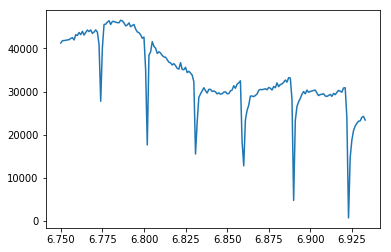

In [140]:
auto_plot1d(data1)

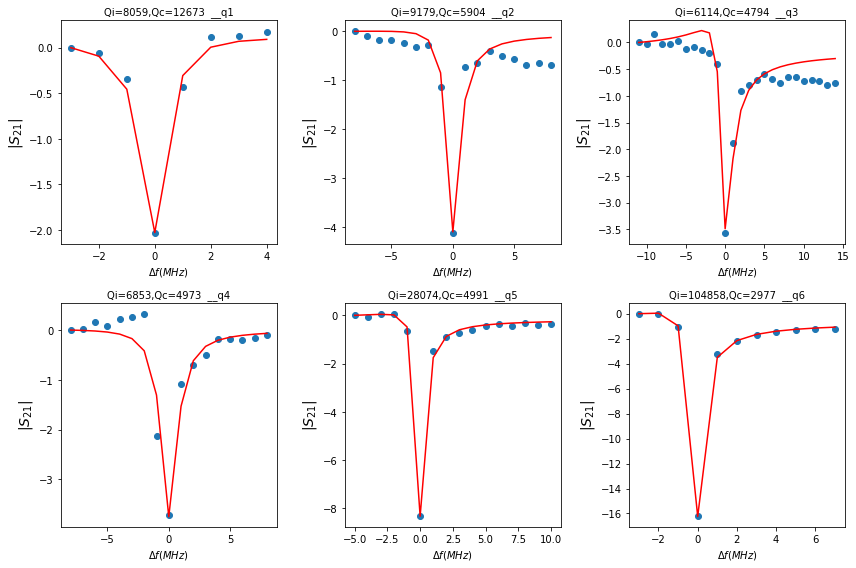

In [151]:
fit_mins = [6.771,6.794,6.820,6.852,6.885,6.920]
fit_maxs = [6.778,6.810,6.845,6.868,6.900,6.930]

fig = plt.figure(figsize=(12, 8))

for i in np.arange(6):
    ax = fig.add_subplot(2,3,i+1)
    fit(data1,fit_min =fit_mins[i],fit_max=fit_maxs[i],des = '_q'+str(i+1),fig = 1)

    
fig.tight_layout()

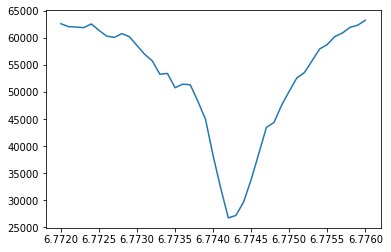

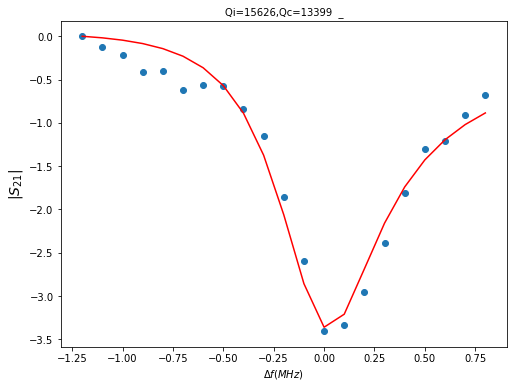

In [165]:
data2 = get_coldata(file_name=filenames[1],col = [0,2,1] , is_reshape = None)
auto_plot1d(data2)

fit(data2,fit_min =6.773,fit_max= 6.775,des = '',para_ini= [1e5,1e5,0])